In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Allow for parent imports (../DemUtils)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
from DemUtils import coreg
import geoutils as gu
import matplotlib.pyplot as plt
import numpy as np

## Load the datasets

In [4]:
reference_dem = gu.georaster.Raster("data/DEM_2009_ref.tif")
dem_to_be_aligned = gu.georaster.Raster("data/DEM_1995.tif")
glacier_mask = gu.geovector.Vector("data/glacier_mask/CryoClim_GAO_SJ_1990.shp")

## Calculate the initial DEM difference

In [5]:
diff_before = reference_dem.data - dem_to_be_aligned.reproject(reference_dem).data

# Load the glacier mask
mask = glacier_mask.create_mask(reference_dem) == 255
# Calculate the off-glacier NMAD
error = 1.4826 * np.nanmedian(np.abs(diff_before.squeeze()[~mask] - np.nanmedian(diff_before.squeeze()[~mask])))
print(f"Error: {error:.1f} m")

Error: 3.4 m


## Plot the DEMs and the initial difference

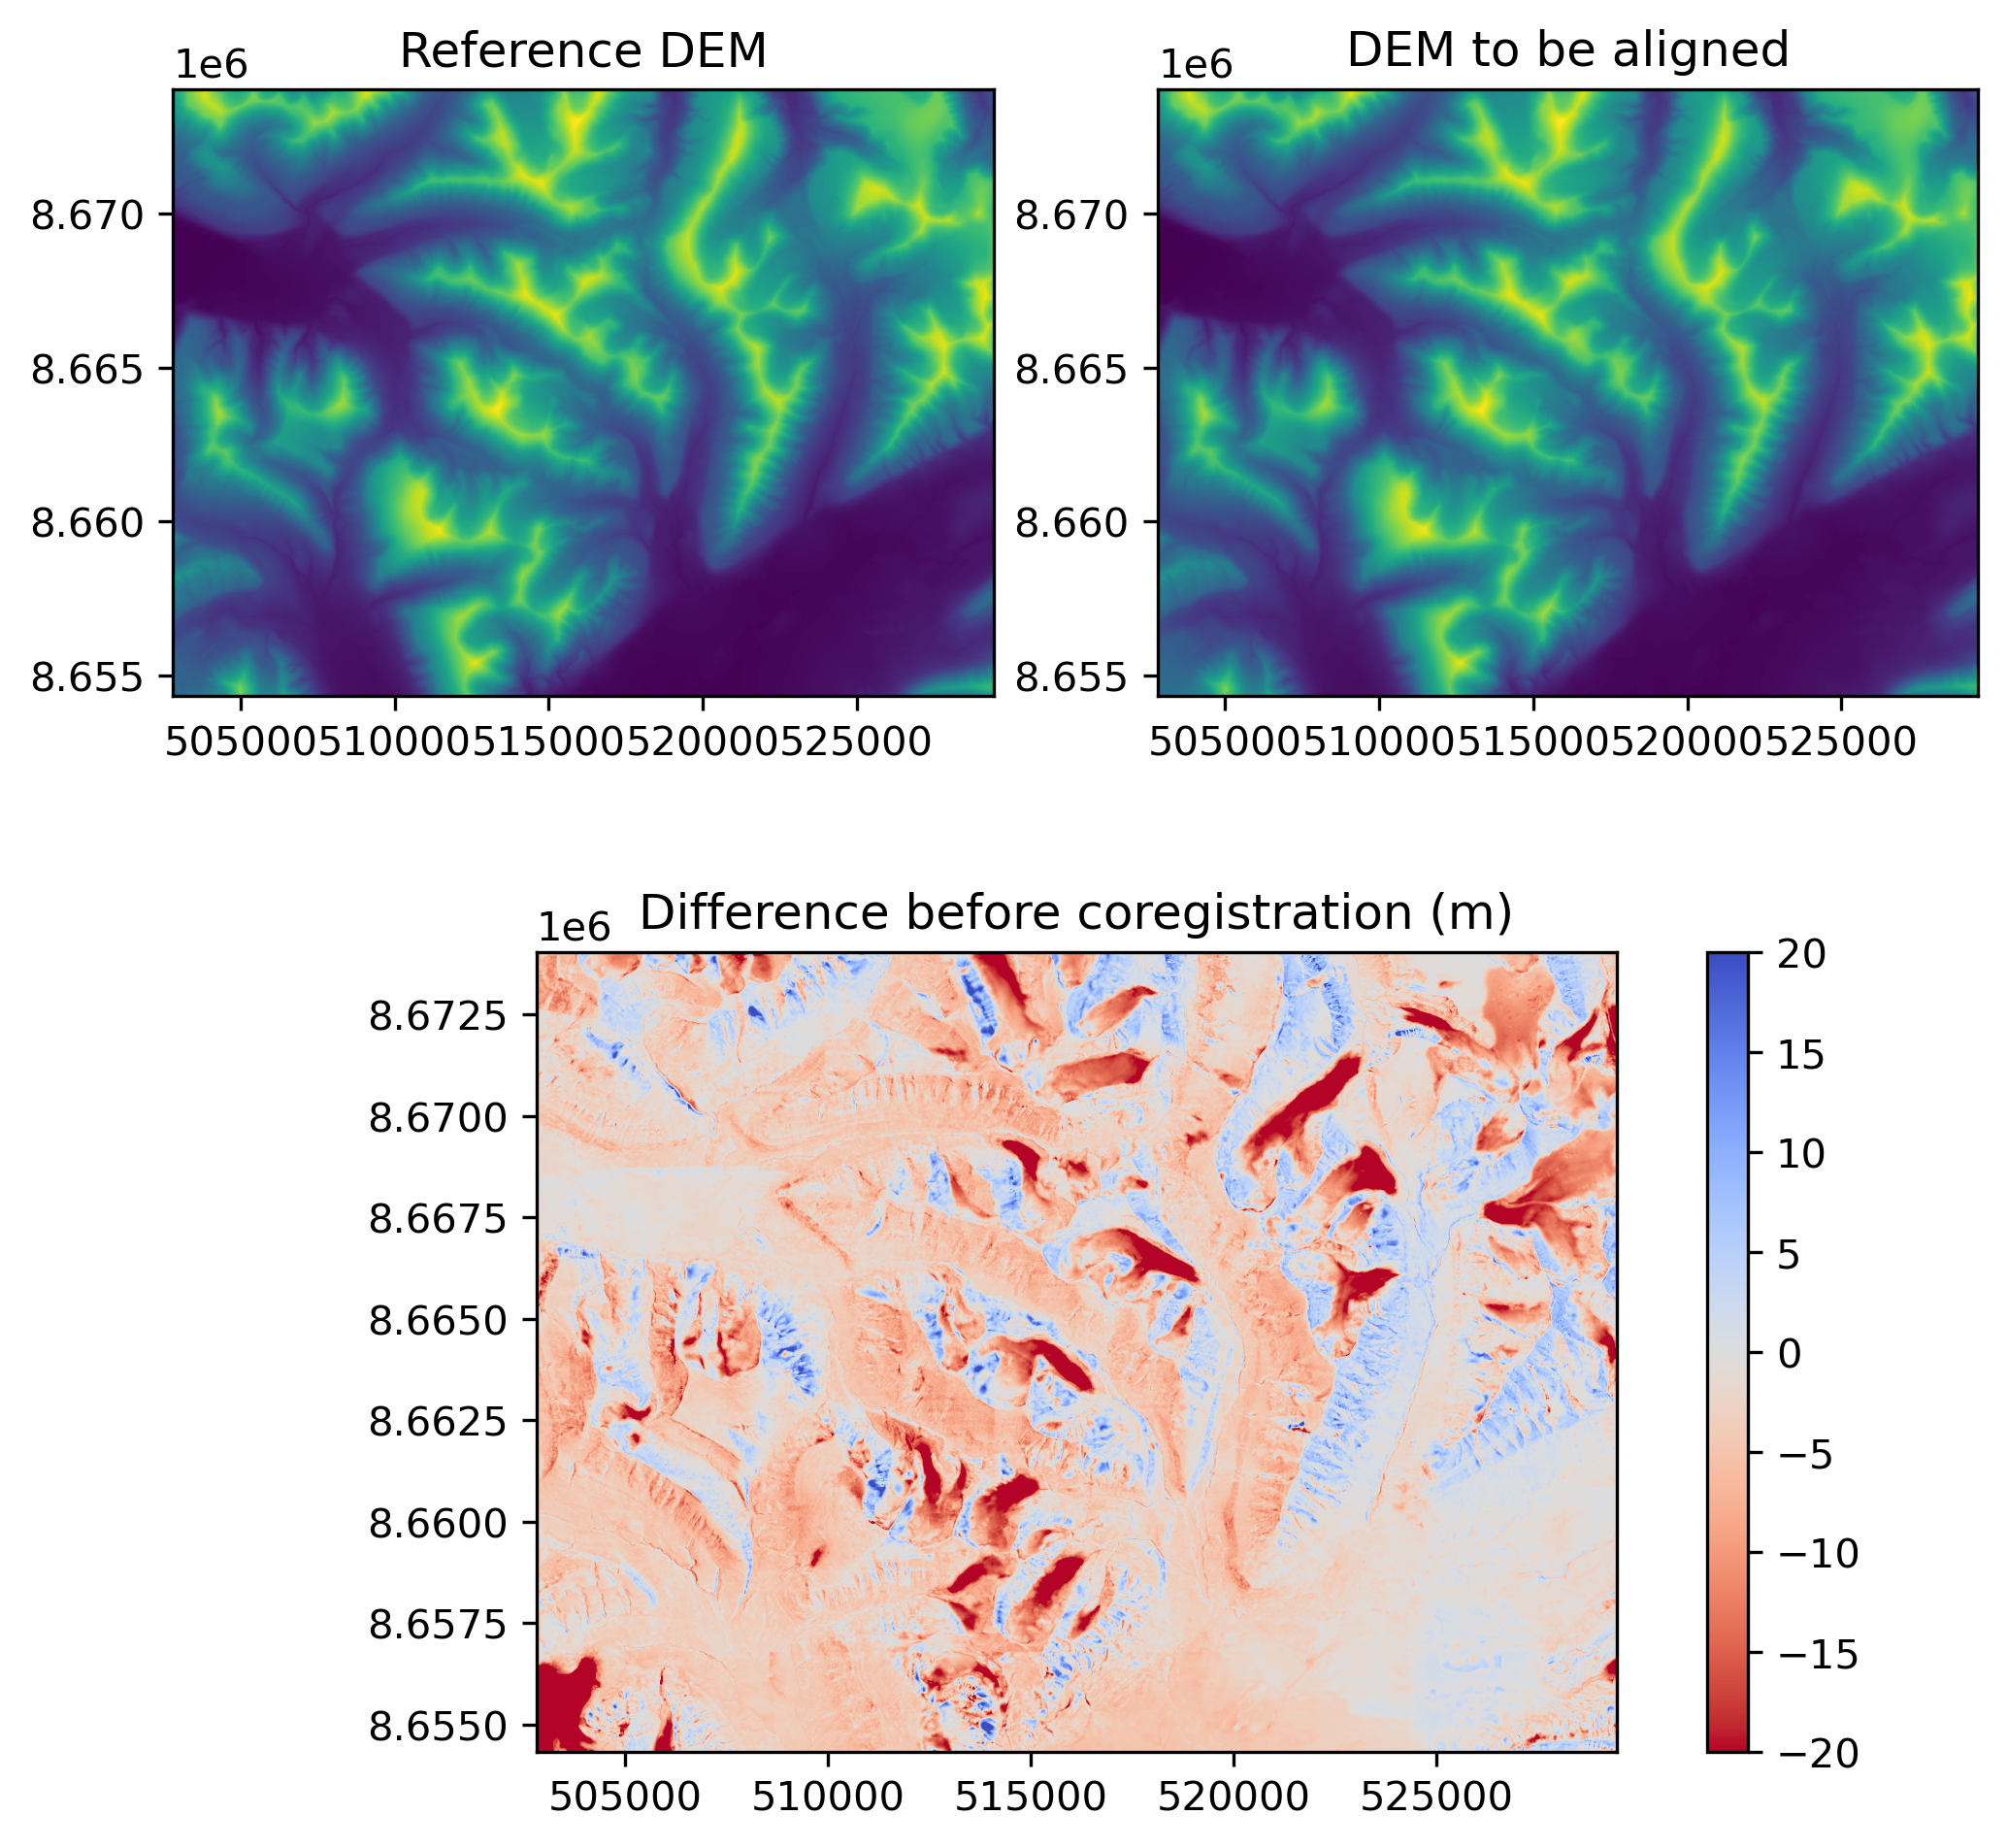

In [6]:
plt.figure(figsize=(8,8), dpi=300)
plt.subplot2grid((2, 2), (0, 0))
plt.title("Reference DEM")
plt.imshow(reference_dem.data.squeeze(), extent=[reference_dem.bounds.left, reference_dem.bounds.right, reference_dem.bounds.bottom, reference_dem.bounds.top])
plt.subplot2grid((2, 2), (0, 1))
plt.title("DEM to be aligned")
plt.imshow(dem_to_be_aligned.data.squeeze(), extent=[dem_to_be_aligned.bounds.left, dem_to_be_aligned.bounds.right, dem_to_be_aligned.bounds.bottom, dem_to_be_aligned.bounds.top])
plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.title("Difference before coregistration (m)")
plt.imshow(diff_before.squeeze(), cmap="coolwarm_r", vmin=-20, vmax=20, extent=[reference_dem.bounds.left, reference_dem.bounds.right, reference_dem.bounds.bottom, reference_dem.bounds.top])
plt.colorbar()

### Show the glacier mask
This steps is only for visualisation and won't affect the result

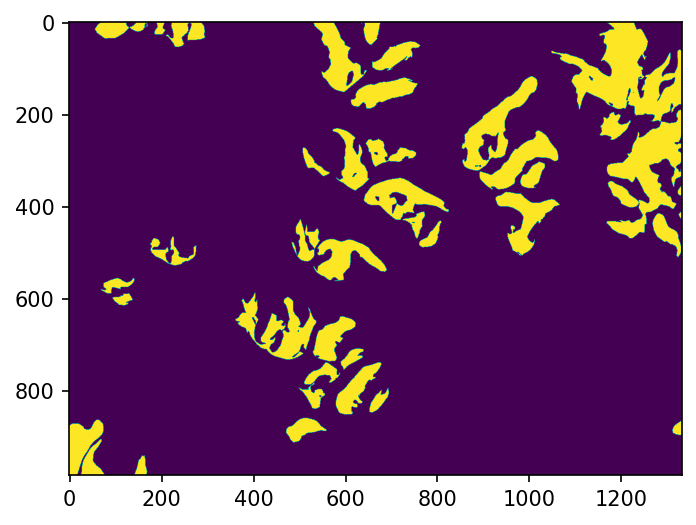

In [7]:
mask = glacier_mask.create_mask(reference_dem) == 255
plt.figure(dpi=150)
plt.imshow(mask)

### Run the ICP coregistration

In [8]:
aligned_dem_icp, icp_error = coreg.coregister(reference_dem,
                                              dem_to_be_aligned,
                                              method="icp",
                                              mask=glacier_mask,
                                              max_assumed_offset=50,
                                              verbose=True)
print(f"Error: {icp_error:.1f} m")

Running ICP coregistration...
Done
Error: 2.9 m


### Run Amaury's "Nuth & Kääb (2011)" coregistration

In [9]:

aligned_dem_amaury, amaury_error = coreg.coregister(reference_dem,
                                                    dem_to_be_aligned,
                                                    method="amaury",  # This also accepts "nuth_kaab"
                                                    mask=glacier_mask,
                                                    verbose=True)
print(f"Error: {amaury_error:.1f} m")

Iteratively correcting dataset: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


Final easting offset: -0.37 px, northing offset: -0.34 px, NMAD: 2.861 m
NMAD after deramping (degree: 1): 2.477 m
Error: 2.5 m


### Calculate DEM differences

In [10]:

diff_icp = reference_dem.data - aligned_dem_icp.data
diff_amaury = reference_dem.data - aligned_dem_amaury.data

### Plot the DEM differences

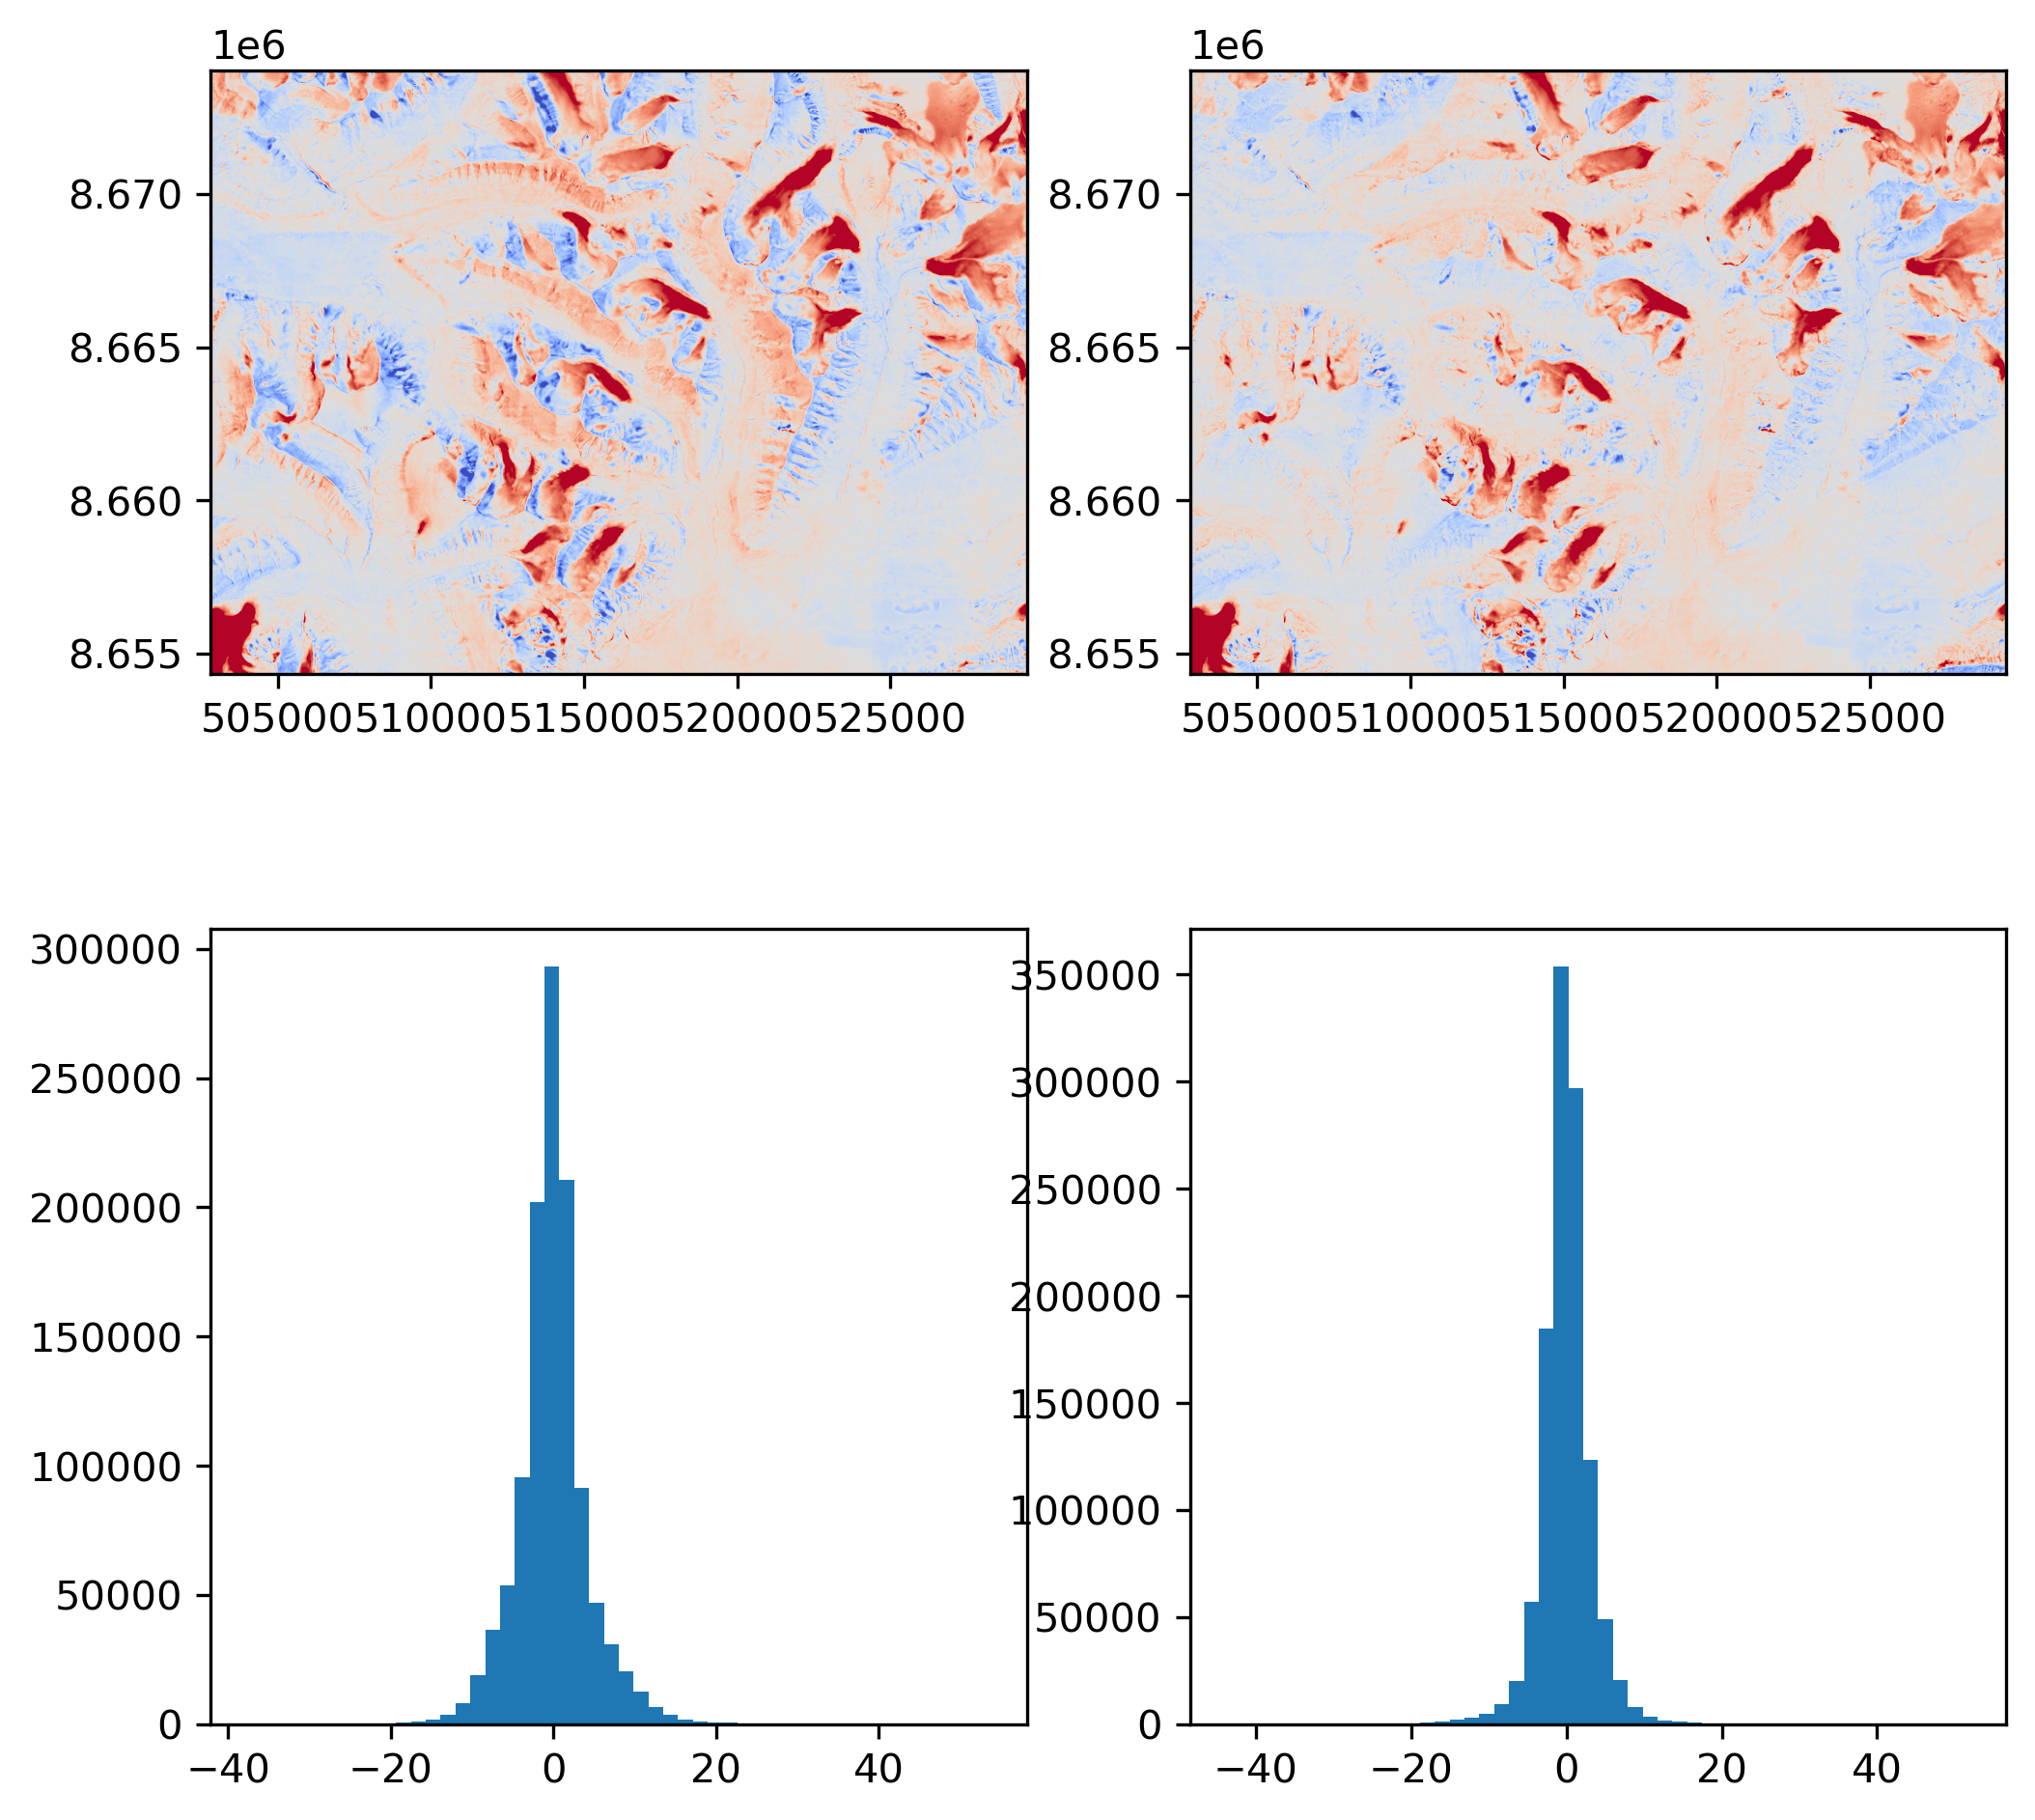

In [11]:
plt.figure(figsize=(8,8), dpi=300)
plt.subplot(221)
plt.imshow(diff_icp.squeeze(), cmap="coolwarm_r", vmin=-20, vmax=20, extent=[aligned_dem_icp.bounds.left, aligned_dem_icp.bounds.right, aligned_dem_icp.bounds.bottom, aligned_dem_icp.bounds.top])
plt.subplot(222)
plt.imshow(diff_amaury.squeeze(), cmap="coolwarm_r", vmin=-20, vmax=20, extent=[aligned_dem_amaury.bounds.left, aligned_dem_amaury.bounds.right, aligned_dem_amaury.bounds.bottom, aligned_dem_amaury.bounds.top])
plt.subplot(223)
plt.hist(diff_icp.squeeze()[~mask], bins=50)
plt.subplot(224)
plt.hist(diff_amaury.squeeze()[~mask], bins=50)
plt.subplots_adjust()

## Doing it all in one expression

In [12]:
! mkdir data/tmp/

In [13]:
coreg.coregister(
    reference_raster="data/DEM_2009_ref.tif",
    to_be_aligned_raster="data/DEM_1995.tif",
    mask="data/glacier_mask/CryoClim_GAO_SJ_1990.shp",
    method="nuth_kaab",
    verbose=True
)[0].save("data/tmp/DEM_1995_coreg.tif")

Iteratively correcting dataset: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Final easting offset: -0.37 px, northing offset: -0.34 px, NMAD: 2.861 m
NMAD after deramping (degree: 1): 2.477 m
